<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C1_Seqeunce2_Recptors_and_Muscles/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a second test for an upcoming text book on computational neuroscience from an optimization/learning perspective. The book will start with evolution because ultimately, all aspects of brain come from evolution and, as we will see, evolution can also be seen as a learning algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

# **Part 1 Behaviour, Environments and Optimization: Evolution and Learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* **environment**, the (statistical) properties of where an organism lives
* **behaviour**, the statistics of what the organism does
* **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment

This very much is the core of why we are writing this book: we can view pretty much anything happening in the brain (and biology) as being part of a process that brings about improvement in this sense.

___
# Chapter 1.1 Behaviour as a Policy in an Environmental Context

### Objective: This chapter develops examples of how behaviour is described and evaluated in relation to its [goodness](## "This is a very loaded term, to be unpacked carefully later") within a specific environmental niche.

You will learn:
*   What is a policy? A policy is a formalization of behaviour as a function that takes an organism's experiences of their environment as an input and outputs the organism's actions.
*   What is a good policy? The rewards and other environmental signals resulting from the organism's actions in the environment are integrated into a Loss/Objective function to evaluatate, and potentially improve, a policy.
*   What is stochasticity? Both the environment and an organism's behavior can contain random elements. This randomness can pose challenges when evaluating policies as it becomes difficult to determine whether poor outcomes are due the policy itself or simply bad luck.

___
# **Sequence 1.1.2: Thinking of What Receptors and Muscles Do as a Policy**

### Objective: In this sequence, we will continue to use the Gridworld environment-organism system to see how behaviour can be abstracted as input --> compute --> output process, and how such processes can be formalized as a **policy** with **parameters**.

Picture showing receptor/input, brain/compute, musceles/output embedded in the environment feedback loop.

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [55]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
import tabulate
import time
import logging
from scipy.spatial.distance import cdist
from IPython.display import display, clear_output, Markdown


def printmd(string):
    display(Markdown(string))


url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/every_util.py"
response = requests.get(url)

# Make sure we got a valid response
if response.status_code == 200:
    with open("every_util.py", 'w') as f:
        f.write(response.content.decode())
else:
    print(f'Failed to download {url}')

%run every_util.py

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


feedback_prefix = "P1C1_S2"


Running in colab
Random seed 2021 has been set.


In [56]:
# @title Plotting Functions
# define some util functions again locally for prototyping,
# push into utils later


def make_grid(num_rows, num_cols, figsize=(7,6)):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  ax.spines[['right', 'top']].set_visible(True)
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)

  # Minor ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)

  ax.xaxis.tick_top()

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  ax.invert_yaxis()
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()

In [57]:
# @title Gridworld Board Object
# define some util functions again locally for prototyping,
# push into utils later


class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game.
  Board state is tracked as a triple (pieces, scores, rounds_left)
  pieces: batch_size x n_rows x n_cols np.array
  scores: batch_size np.array
  rounds_left: batch_size np.array

  Pieces are interpreted as:
  1=critter, -1=food, 0=empty

  First dim is batch, second dim row , third is col, so pieces[0][1][7]
  is the square in row 2, in column 8 of the first board in the batch of boards

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, lifetime=30,
               rng = None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = np.ones(self.batch_size) * self.lifetime
    self.scores = np.zeros(self.batch_size)
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+1 because we want critter and food locations
      int_loc, rc_idx, rc_plot = init_loc(self.n_rows,
                                          self.n_cols,
                                          self.num_food+1,
                                          rng=self.rng)
      # critter random start location
      self.pieces[(ii, rc_idx[0][0], rc_idx[1][0])] = 1
      # food random start locations
      self.pieces[(ii, rc_idx[0][1:], rc_idx[1][1:])] = -1
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy()}
    return state


  def set_state(self, board):
    """ board is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy()}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves, rng=None):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new x coord for each critter
        on each board and the third gives the new y coord.

    Note:
      Assumes that there is exactly one valid move for each board in the
      batch of boards. i.e. it does't check for bounce/reflection on edges,
      or for multiple move made on the same board. It only checks for eating
      food and adds new food when appropriate. Invalid moves could lead to
      illegal teleporting behavior, critter dublication, or index out of range
      errors.
    This assumes the move is valid, i.e. doesn't check for
    bounce/reflection on edges, it only checks eating and adds new food,
    so invalid moves could lead to illegal teleporting behaviour or index out
    of range errors
    """
    if rng is None:
      rng = self.rng
    #critters leave their spots
    self.pieces[self.pieces==1] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    self.scores = self.scores + eats_food

    num_empty_after_eat = self.n_rows*self.n_cols - self.num_food
    # -1 for the critter +1 for food eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    if np.any(eats_food):
      # add random food to replace what is eaten
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = rng.choice(num_empty_after_eat, size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    # put critters in new positions
    self.pieces[moves] = 1.0
    self.rounds_left = self.rounds_left - 1
    assert np.all(self.pieces.sum(axis=(1,2)) == ((self.num_food * -1) + 1))


  def get_legal_moves(self):
    """
    Identifies all legal moves for the critter, taking into acount
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    #apply all possible offsets to each game
    moves = np.stack([
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0,  1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, -1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0,  1])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0, -1])]*self.batch_size).T]).swapaxes(0,2)

    #check bounces at boundaries
    moves[:,1,:] = np.where(moves[:,1,:] >=
                            self.n_rows, self.n_rows-2, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] >=
                            self.n_cols, self.n_cols-2, moves[:,2,:])
    moves[:,1,:] = np.where(moves[:,1,:] < 0, 1, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] < 0, 1, moves[:,2,:])
    return moves


  def get_perceptions(self, radius):
    """
    Generates a vector representation of of the critter perceptions, oriented
    around the critter. get_precept_filter is used to get a canonical version
    of the board with unknonw positions ocluded

    Args:
      radius: int, how many grid squared the critter can see around it
        using L1  (Manhattan/cityblock) distance

    Returns:
      A batch_size x 2*radius*(radius+1) + 1, giving the values
      of the percept reading left to right, top to bottom over the board,
      for each board in the batch
    """
    # define the L1 ball mask
    diameter = radius*2+1
    mask = np.zeros((diameter, diameter), dtype=bool)
    mask_coords = np.array([(i-radius, j-radius)
      for i in range(diameter)
        for j in range(diameter)])
    mask_distances = cdist(mask_coords, [[0, 0]],
                           'cityblock').reshape(mask.shape)
    mask[mask_distances <= radius] = True
    mask[radius,radius] = False  # exclude the center

    # pad the array
    padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
     (radius, radius)), constant_values=-2)

    # get locations of critters
    critter_locs = np.argwhere(padded_arr == 1)

    percepts = []
    for critter_loc in critter_locs:
      b, r, c = critter_loc
      surrounding = padded_arr[b, r-radius:r+radius+1, c-radius:c+radius+1]
      percept = surrounding[mask]
      percepts.append(percept)
    return(np.array(percepts))


In [58]:
gwb = GridworldBoard(batch_size=4)

In [59]:
gwb.get_init_board_state()

{'pieces': array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0., -1.,  0.,  0., -1.,  0.],
         [ 1., -1., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1., -1., -1.]],
 
        [[ 0.,  0., -1.,  1.,  0.,  0., -1.],
         [ 0., -1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0., -1.]],
 
        [[-1.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  0., -1.,  0.,  0.,  0., -1.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0., -1.],
         [ 0., -1.,  0.,  0., -1.,  0.,  0.]],
 
        [[ 0., 

In [61]:
gwb.get_perceptions(2)

array([[-1., -2.,  0.,  0., -2., -2., -1., -1., -2.,  0.,  0.,  0.],
       [-2., -2., -2., -2.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -2.,  0., -1., -2., -2.,  0., -1., -2.,  0., -1.,  0.],
       [-1.,  0.,  0.,  0., -2., -1., -1.,  0., -1.,  0.,  0.,  0.]])

In [62]:
# @title Gridworld Game Object
# define some util functions again locally for prototyping,
# push into utils later




class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """
  square_content = {
      -1: "X", #Food
      +0: "-", #Nothing
      +1: "O"  #Critter
      }


  def get_square_piece(self, piece):
    return GridworldGame.square_content[piece]


  def __init__(self, batch_size, n_rows, n_cols,
               num_food, lifetime, rng=None):
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(self.batch_size, self.n_rows, self.n_cols,
                       self.num_food, self.lifetime, rng=self.rng)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a sinlge board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,x,y coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 2-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to x,y indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def string_rep_readable(self, board, g):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.square_content[square] for row in board['pieces'][g]
                       for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g):
    """Dispalys the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g):
    return np.squeeze(np.array(np.where(board['pieces'][g]==1)))


  def plot_board(self, board, g,
                 fig=None, ax=None, critter=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war
                 radius=2,
                 figsize=(6,5),
                 critter_name='Critter'):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize)
    rc_critter = self.get_critter_rc(board, g)

    if critter is None:
      critter = plot_critter(fig, ax, rc_critter,
                             critter_name=critter_name)
    else:
      critter = plot_critter(fig, ax, rc_critter,
                             critter, critter_name=critter_name)
    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T

    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    if fov is None:
      fov = plot_fov(fig, ax, rc_critter, n_rows, n_cols,
                     radius, has_fov)
    else:
      fov = plot_fov(fig, ax, rc_critter, n_rows, n_cols,
                     radius, has_fov, fov)

    if legend_type == 'included':
      fig.legend(loc = "outside right upper")
      fig.canvas.draw()
      return fig, ax, critter, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(2,2), layout='constrained')
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center')
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter, food, fov


  def get_valid_actions(self, board):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board[pieces].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves()
    valids = np.zeros((batch_size, n_rows * n_cols))
    for ii, g in enumerate(legal_moves[:,1:,:]):
      for x,y in zip(g[0],g[1]):
        valids[ii, x*self.n_cols+y] = 1
    return valids


  def display_moves(self, board, g):
    """Dispaly possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board)[g], (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for y in range(self.n_cols):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.n_cols):
      print(y, "|", end="")    # Print the row
      for x in range(self.n_rows):
        piece = A[y][x]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")


  def get_next_state(self, board, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: list of integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board tiple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parellel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
      b = GridworldBoard(len(actions), n_rows, n_cols,
                         self.num_food, self.lifetime,
                         rng=self.rng)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        newPieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        newScores = np.array([board['scores'][ai].copy() for ai in a_indx])
        newrounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        b.set_state((newPieces, newScores, newrounds_left))
      b.execute_moves(moves)
      return b.get_state()


  def critter_oriented_get_next_state(self, board, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1)}
    critter_locs = np.where(board['pieces'] == 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    b.execute_moves(moves)
    return(b.get_state())


  def action_to_critter_direction(self, board, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right'
    """
    offset_dict = {(0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == 1)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      batch size np.array of -1 if not ended, and scores for
      each game in the batch if it is ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores

In [63]:
# @title Interactive Gridworld Game Widgets
# define some util functions again locally for prototyping,
# push into utils later




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, random_seed=None,
               has_fov=False, radius=2, collect_fov_data=False,
               figsize=(6,5), critter_name='Critter'):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.rng = np.random.default_rng(seed=random_seed)
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    self.critter_name = critter_name
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
        width='300px', height='160px'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
        width='200px', height='100px'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
        width='400px', height='300px'))
    self.up_button = widgets.Button(description="Up")
    self.down_button = widgets.Button(description="Down")
    self.left_button = widgets.Button(description="Left")
    self.right_button = widgets.Button(description="Right")
    self.start_button = widgets.Button(description="Start")
    self.random_movement = widgets.Checkbox( value=False,
                                            description='Move Randomly',
                                             disabled=False,
                                             indent=False)
    # get plot canvas widgets and other plotting objects
    plt.ioff()
    (self.b_fig, self.b_ax, self.b_critter, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, 0, has_fov=self.has_fov,
                             radius=self.radius, figsize=self.figsize,
                             critter_name=self.critter_name)
    # lump base widgets together for different display purposes
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    self.output_and_score = widgets.HBox([self.scoreboard, self.output])
    self.output_score_start = widgets.HBox([self.scoreboard, self.output,
                                            self.start_button])
    self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                            self.buttons])
    # this one for just the random player
    self.board_output_score_start = widgets.VBox(
        [self.b_fig.canvas, self.output_score_start],
        layout=widgets.Layout(justify_content='flex-start'))
    # this one for just the random player when recording
    self.board_output_score_table = widgets.HBox(
        [self.board_output_score_start, self.fov_eat_table_display],
        layout=widgets.Layout(justify_content='flex-start'))
    #these ones for human in control with or without recording
    self.board_buttons_and_score = widgets.VBox(
        [self.board_and_buttons, self.output_and_score],
        layout=widgets.Layout(justify_content='flex-start'))
    self.board_buttons_score_table = widgets.HBox(
        [self.board_buttons_and_score, self.fov_eat_table_display],
                layout=widgets.Layout(justify_content='flex-start'))
    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:', '--'],
               ['Last Score:', '--'],
               ['Average Score:', '--']]
      print(tabulate(table))
    with self.output:
      print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))
    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_score = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]
    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, [which_button])
    new_score = self.board_state['scores'][0]
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left
    if new_score > old_score: #eating happened
      eating_string = "The critter ate the food there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig, self.b_ax, self.b_critter, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_critter, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      print("The critter (tried) to move " + which_button +
            " and is now at ({}, {}).".format(row,col))
      print(eating_string)
      print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
          rounds_left, new_score, new_score / num_moves))
    if rounds_left == 0:
      self.final_scores.append(new_score)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_score))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_critter, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_critter, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.final_scores) > 0:
          table = [
            ['High Score:', str(np.max(np.array(self.final_scores)))],
            ['Last Score:', str(self.final_scores[-1])],
            ['Average Score',
             '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['High Score:', '--'],
                   ['Last Score:', '--'],
                   ['Average Score:', '--']]
        print(tabulate(table))
    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime):
        self.random_click()
    self.start_button.disabled = False


  def random_click(self):
    move = self.rng.integers(0,4)
    if move == 0:
      self.up_button.click()
    elif move == 1:
      self.down_button.click()
    elif move == 2:
      self.left_button.click()
    elif move == 3:
      self.right_button.click()
    else:
      print('should not happen')




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while
  an artificial player plays an identical board
  """

  def __init__(self, gridworld_game, init_board=None, player=None,
               random_seed=None, has_fov=False, radius=2,
               collect_fov_data=False, critter_name='Critter'):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player: object with a play method that takes a board state
        as an argument and returns a move if left out will use a random player
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.rng = np.random.default_rng(seed=random_seed)
    self.final_scores = []
    self.player = player
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.critter_name = critter_name
    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board

    # both players play on the same board
    self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()

    # Initialize widgets and buttons
    self.output0 = widgets.Output()
    self.output1 = widgets.Output()
    self.scoreboard = widgets.Output()
    self.up_button = widgets.Button(description="Up")
    self.down_button = widgets.Button(description="Down")
    self.left_button = widgets.Button(description="Left")
    self.right_button = widgets.Button(description="Right")

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_critter0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legned) = self.gwg.plot_board(
        self.board_state, 0, legend_type='separate', figsize=(5,4),
        has_fov=self.has_fov, radius=self.radius,
        critter_name = self.critter_name)
    (self.b_fig1, self.b_ax1, self.b_critter1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, legend_type=None,
                             figsize=(5,4), has_fov=self.has_fov,
                             radius=self.radius)

    self.board_buttons_and_output0 = widgets.VBox([self.b_fig0.canvas,
                                                   self.buttons,
                                                   self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])
    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    self.boards_and_scores = widgets.HBox([self.board_buttons_and_output0,
                                           self.legend_and_scores,
                                           self.board_and_output1])

    # initial text outputs
    with self.output0:
      print('\tClick a button to start.')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', 'YOU', 'THEM'],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_scores = old_board['scores']
    if self.player is None:
      move = self.rng.integers(0,4)
      if move == 0: a_player = 'up'
      elif move == 1: a_player = 'down'
      elif move == 2: a_player = 'right'
      elif move == 3: a_player = 'left'
    else:
      a_player, _, _ = self.player.play(old_board)
      a_player = self.gwg.action_to_critter_direction(old_board, a_player)
      a_player = a_player[1]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)
    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, [which_button, a_player])
    new_scores = self.board_state['scores']
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "The critter ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "The critter ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig0, self.b_ax0, self.b_critter0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_critter0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1)
    (self.b_fig1, self.b_ax1, self.b_critter1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_critter1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)

    with self.output0:
      clear_output()
      print("\tYou clicked the " + which_button +
            " button and your critter is now at ({}, {}).".format(row0,col0))
      print("\t"+eating_string0)
      print("\tRounds Left: {} \tFood Eaten: {} \tFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      print("\tThe other player (tried) to move " + a_player +
        " and is now at ({}, {}).".format(row1,col1))
      print("\t"+eating_string1)
      print("\tRounds Left: {} \tFood Eaten: {} \tFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()
      (self.b_fig0, self.b_ax0, self.b_critter0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_critter0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_critter1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_critter1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      with self.output0:
        clear_output
        print('\tGame Over. Final Score {}'.format(new_scores[0]))
        print('\tResetting the board for another game')
      with self.output1:
        clear_output
        print('\tGame Over. Final Score {}'.format(new_scores[1]))
        print('\tResetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', 'YOU', 'THEM '],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', 'YOU', 'THEM'],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')


  def random_click(self):
    move = self.rng.integers(0,4)
    if move == 0:
      self.up_button.click()
    elif move == 1:
      self.down_button.click()
    elif move == 2:
      self.left_button.click()
    elif move == 3:
      self.right_button.click()
    else:
      print('should not happen')

# 1.1.2.1: Limited Perception

In the previous sequence, you and the organism were effectively omnicient, i.e. had both complete and accurate knowledge of the state of the environment. This is also the case when playing games like go or chess where all relevant information is available. However, the cases of total knowledge are unusual and artificial exceptions to the general situation faced by all living organism where the current state of the environment is only known in part. Inspired by weakly electric fish (see e.g. the work of Malcolm MacIver), we now introduce a new organism, *Fishy*, who only percieves the 12 cells of the Gridworld immediately adjecent (i.e. the cells within a radius of 2 using $L_1$ distance). For now, *Fishy* just swims around randomly on the grid. Let's see what that looks like.

In [64]:
# @title Random Movement with Limited Perception
# @markdown Don't worry about how this code works – just **run this cell** and press the start button to see what *Fishy's* limited field of perception looks like.
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(1, 7, 7, 10, 30, rng=rng)
random_igwg = InteractiveGridworld(gwg, has_fov=True,
                                   critter_name='$\mathit{Fishy}$')
display(random_igwg.b_fig.canvas)
clear_output()
display(random_igwg.board_output_score_start)

Now that we have an organism with a limited field of perception, it's time for a micro-science question. Are *Fishy's* perceptions of the environment predictive of whether or not they will eat food? Make a guess. Think about how you would prove to yourself whether your guess is right. There are lots of ways you could do it, let's walk through one of them now. First we observe the behavior and collect data! (Basically any way of validating your guess that purports to be science will start this way, with data. Good to remember that there are other ways of thinking out there, e.g., a theorist or mathematician might skip observations and data and just start making deductions based on assumptions about abstractions, but that's not what we're doing here and now.)

In [65]:
# @title Observations of Random Movement with Limited Perception
# @markdown Don't worry about how this code works – just **run this cell**, then press the start button and watch the data collection happen.
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(1, 7, 7, 10, 30, rng=rng)
record_igwg = InteractiveGridworld(gwg, has_fov=True, collect_fov_data=True,
                                   critter_name='$\mathit{Fishy}$')
display(record_igwg.b_fig.canvas)
clear_output()
display(record_igwg.board_output_score_table)

Run two or three simulations to collect 'enough' data for analysis.

**Thought/Bonus/Further Reading: How much data is enough?!?:**

Entire methodologies have been developed to answer this critical question. Power analysis determines optimal sample size considering factors like expected effect size and desired statistical power in a hypothesis testing framework. Empirical risk minimization is a strategy in machine learning to estimate model parameters and assess the amount of data needed. On the other hand, Bayesian methods, with their iterative updating process, allow for a continual reassessment of whether enough data has been collected based on the convergence of posterior distributions.

Now that we have some observations let's get them in a format we can work with:

In [66]:
data = record_igwg.fov_eat_table_data
display(data)

array([[48., 24., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

When analyzing data we ***always*** plot the data before doing ***anything*** else. Which visulization to start with is a more subjective question, though histograms and scatter plots are often good starting points. In this case we'll go for a [histogram](## "In a histogram each bin represents a range of values, and the height of the bar shows the frequency (number of data points observed) within that range.") of the two distributions of number of food items percieved conditional on whether eating happened immediately afterward or not. Before you run the code below to generate the picture, think about what it might look like.

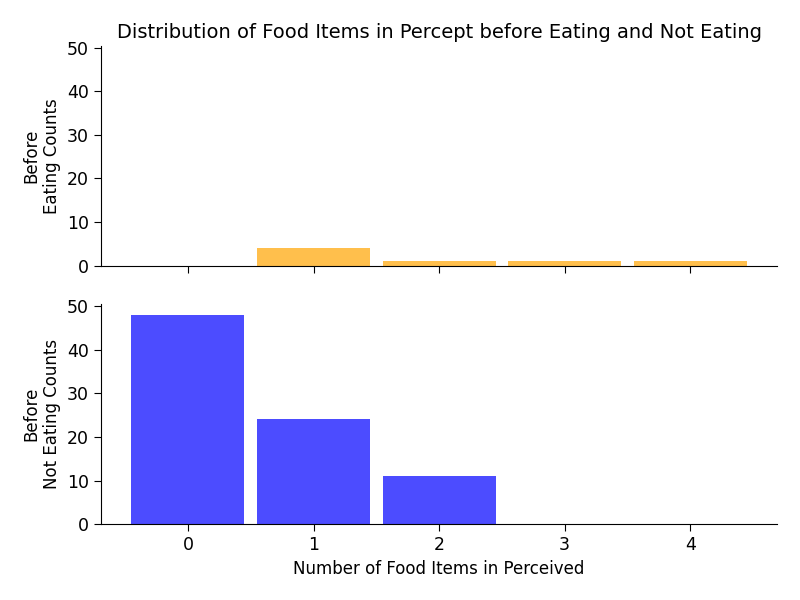

In [67]:
# Unpack the contingency table into a list of raw observations
not_eating = np.repeat(range(len(data[0])), data[0].astype(int))
eating = np.repeat(range(len(data[0])), data[1].astype(int))

# Create histograms
fig_hist, (ax1_hist, ax2_hist) = plt.subplots(2, 1, sharex=True, sharey=True,
                                              figsize=(8,6))
# Define bin edges
nonzero_col_index = np.where(data > 0)[1]
bin_edges = np.arange(-0.5, np.max(nonzero_col_index) + 1.5, 1)
ax2_hist.hist(not_eating, bins=bin_edges, color='blue', alpha=0.7, rwidth=0.9)
ax1_hist.hist(eating, bins=bin_edges, color='orange', alpha=0.7, rwidth=0.9)
ax1_hist.set_title('Distribution of Food Items in Percept before Eating and Not Eating',
                   fontsize=14)
#ax2_hist.set_title('Eating')
ax1_hist.set_ylabel('Before\nEating Counts', fontsize=12)
ax2_hist.set_ylabel('Before\nNot Eating Counts', fontsize=12)
ax2_hist.set_xlabel('Number of Food Items in Perceived', fontsize=12)
remove_ip_clutter(fig_hist)
plt.tight_layout()
plt.show()

These histograms reveal differences in the distribution of perceived food items immediately before 'Eating' and 'Not Eating' events. 'Not Eating' is more frequently observed, especially when fewer food items are perceived beforehand. On the other hand, 'Eating' events, although less common, tend to occur more often when more food items are perceived. These initial observations hint that the perception of food may be predictive of eating.

To get at our question of whether perceiving food is predictive of eating more directly we will now plot the proportion of times eating followed for the different numbers of food items percieved. Again, before you run the code below to generate the picture, think about what it might look like.

In [68]:
################################################################################
# TODO for students: Replace ... in the line:
# prob_eating plot_data[...] / plot_data.sum(axis=...)
# Comment out or remove this next lines.
raise NotImplementedError("Exercise: plot proportion of eating")
################################################################################

# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)[0]
plot_data = data[:, non_zero_cols]
prob_eating = plot_data[...] / plot_data.sum(axis=...)
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
# Display the plot
plt.show()

NotImplementedError: ignored

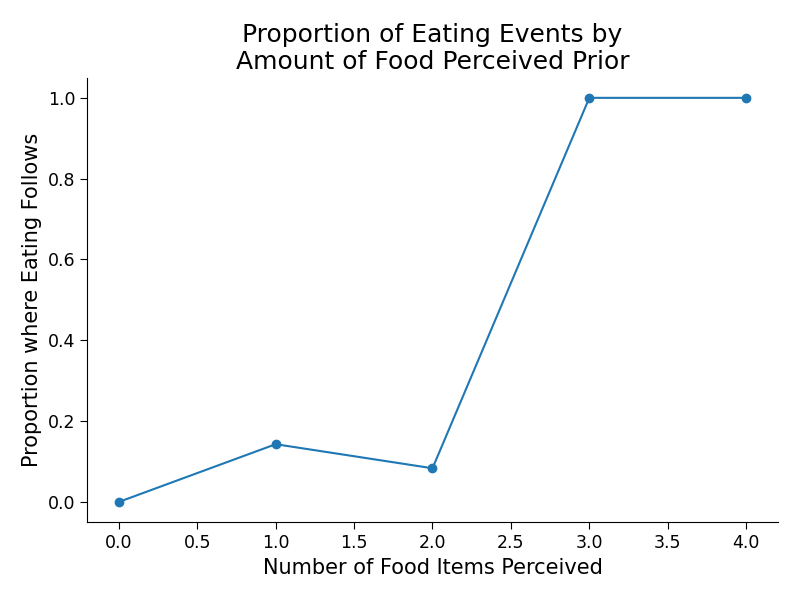

In [69]:
# to_remove solution
# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)[0]
plot_data = data[:, non_zero_cols]
prob_eating = plot_data[1] / plot_data.sum(axis=0)
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
# Display the plot
plt.show()

In this plot the trend appears to be that the proportion of eating events increases as the amount of food perceived immediately prior increases. This suggests that the amount of food perceived is indeed predictive of eating. However, this is just a visualization and not a formal test of a causal relationship. Later in the book we review how to formally assess predictiveness through statistical models, such as logistic regression, which would be suitable for this case of predicting a binary outcome (eating vs. not eating) from a predictor variable (or variables) like the amount of food percieved.

Bonus: Think about what makes a good predictor variable:

We observed and recorded the total number of food items percieved and used that as our 'predictor' variable in analysis above. Is there other aspects or functions of *Fishy's* perceptions that would make better predictors than total number of food items percieved? (Hint: the predictor variable could take relative location of food items within the perceptive field into account.) [Solution.](## "In terms of predicting immediate eating, really only the four grid cells immediately adjacent to *fishy* can have any bearing on whether eating will happen in the next round, so the sum of food items just in those for cells would be a much better predictor. Note that we haven't gotten into what 'better' means yet for a predictor so this question is kind of ill formed, but we will evenutally and these are good things to start thinking about from the get go.")

# 1.1.2.2: Perception Guiding Actions is a Policy

We've seen that even in the case of random drifting, perceptions of the environment can carry information about import things like whether or not eating will happen. Now, we're going to hook this percptive field up to some highly abstracted muscles by coming up with a simple set of rules that translate *Fishy's* perceptions into a choice of actions (up, down, left, right).

Before we attempt this we need to know about the form of *Fishy's* perceptions. We recorded some of these in the previous section, what do they look like?

In [70]:
# record_igwg is an instance of an InteractiveGridworld object
# that we ran in the cell above to record data
print(type(record_igwg))

<class '__main__.InteractiveGridworld'>


In [71]:
# It has a percept_eat_records attribute which is list of all the records
# from the games played by that object since it was instantiated
print(type(record_igwg.percept_eat_records))

<class 'list'>


In [72]:
#Its length should be 30 x number of time you ran the simulation
print(len(record_igwg.percept_eat_records))

90


What does a record look like?

In [77]:
# take a look at the first two elements of the list
print(type(record_igwg.percept_eat_records[0]))
print('----------------------------------')
display(record_igwg.percept_eat_records[0])
print('----------------------------------')
display(record_igwg.percept_eat_records[1])

<class 'dict'>
----------------------------------


{'perception': array([-2., -2., -2., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]),
 'state': {'pieces': array([[[-1.,  0.,  0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
          [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
          [ 0.,  0., -1., -1.,  0.,  0.,  0.],
          [ 0.,  0., -1.,  0., -1.,  0.,  0.],
          [ 0., -1.,  0.,  0., -1.,  0., -1.]]]),
  'scores': array([0.]),
  'rounds_left': array([30.])},
 'did_eat': False}

----------------------------------


{'perception': array([-2., -2., -2., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'state': {'pieces': array([[[-1.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
          [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
          [ 0.,  0., -1., -1.,  0.,  0.,  0.],
          [ 0.,  0., -1.,  0., -1.,  0.,  0.],
          [ 0., -1.,  0.,  0., -1.,  0., -1.]]]),
  'scores': array([0.]),
  'rounds_left': array([29.])},
 'did_eat': False}

Looks like each element of the list is a dictionary, with relatively descriptive keys. Let's walk through on of these records element by element.

*   `perception`: a length 12 array with -2's corresponding to places where the perceptual field is outside of the boundaries of the girdworld, 0's corresponding to empty spaces on the grid, and -1's corresponding to food locations.
*   `state`: another dictionary giving state of the board at the time of the perception. The `pieces` element of `state` is a 7x7 array giving the grid positions of the organism (1), the food (-1's), and the empty space (0's). The `scores` and `rounds_left` are exactly what they describe.
* `did_eat`: a boolean indicator of whether or not eating happened on the round immediately following the perception.





Can you see how the perceptive field as defined below is overlaid on the 7x7 arrays above to generate perceptions?

In [78]:
# define the L1 ball mask the determines what an organism perceives
radius = 2
diameter = radius*2+1
mask = np.zeros((diameter, diameter), dtype=bool)
mask_coords = np.array([(i-radius, j-radius)
  for i in range(diameter)
    for j in range(diameter)])
mask_distances = cdist(mask_coords, [[0, 0]], 'cityblock').reshape(mask.shape)
mask[mask_distances <= radius] = True
mask[radius,radius] = False  # exclude the center
display(mask)

array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True, False,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]])

The indices of the perception correspond to the spaces around the organism as follows. Note the the organism doesn't have an orientation with respect to the gridworld, and everything is defined with respect to an absolute/cardinal 'up', 'down', 'left', 'right'.

In [21]:
numbered_mask = np.ones(mask.shape) * -1
numbered_mask[mask] = range(mask.sum())
display(numbered_mask)

array([[-1., -1.,  0., -1., -1.],
       [-1.,  1.,  2.,  3., -1.],
       [ 4.,  5., -1.,  6.,  7.],
       [-1.,  8.,  9., 10., -1.],
       [-1., -1., 11., -1., -1.]])

In [22]:
# in human readable terms the perception is organized as
human_readable_percept_structure = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']

Now that we have a sense of what a perception looks like let's build a function that takes a perception as an input and returns one of four possible moves as an output. To start if there is any food immediately beside the organism it the organism should move towards it, otherwise it should

In [79]:
# @markdown Run this cell to set up the tests for the code exercise below
def test_action_from_perception(test_func):
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']

  # Test when there's no food nearby
  perception = np.zeros(12)
  assert test_func(perception) in ['up', 'down', 'left', 'right']

  # Test when there's food to the near up
  perception = np.zeros(12)
  perception[percept_struct.index('near up')] = -1
  assert test_func(perception) == 'up'

  # Test when there's food to the near down
  perception = np.zeros(12)
  perception[percept_struct.index('near down')] = -1
  assert test_func(perception) == 'down'

  # Test when there's food to the near left
  perception = np.zeros(12)
  perception[percept_struct.index('near left')] = -1
  assert test_func(perception) == 'left'

  # Test when there's food to the near right
  perception = np.zeros(12)
  perception[percept_struct.index('near right')] = -1
  assert test_func(perception) == 'right'

  # Test when there's food in multiple nearby directions
  perception = np.zeros(12)
  perception[percept_struct.index('near up')] = -1
  perception[percept_struct.index('near right')] = -1
  assert test_func(perception) in ['up', 'right']

  # Test when there's food in multiple nearby directions
  perception = np.zeros(12)
  perception[percept_struct.index('near left')] = -1
  perception[percept_struct.index('near down')] = -1
  assert test_func(perception) in ['down', 'left']

  print('Congrats, Tests Passed')

In [80]:
################################################################################
# TODO for students: Complete the lines with ...  to identify directions where
# food is nearby and then randomly choose between directions with nearby food
# if food is nearby. Then comment out the line below and see if your code
# runs and passes the code checks.
raise NotImplementedError("Exercise: make actions depend on perception")
################################################################################


def simple_action_from_percept(percept):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # Defines directions corresponding to different perception indices
  direction_struct = [
    'None', 'None', 'up', 'None',
    'None', 'left', 'right', 'None',
    'None', 'down', 'None', 'None']
  # these are what count as nearby in the percpt
  nearby_directions = ['near up', 'near down', 'near left', 'near right']
  # Get the corresponding indices in the percept array
  nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
  # Identify the directions where food is located
  food_indices = [index for index in nearby_indices if percept[index] == ...]
  food_directions = [direction_struct[index] for index in food_indices]
  if len(food_directions) > 0:  # If there is any food nearby
    # If there is any food nearby randomly choose a direction with food
    return np.random.choice(...)  # Move towards a random one
  else:
    # If there is no food nearby, move randomly
    return np.random.choice(['up', 'down', 'left', 'right'])

test_action_from_perception(simple_action_from_percept)

NotImplementedError: ignored

In [81]:
# to_remove solution
def simple_action_from_percept(percept):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # Defines directions corresponding to different perception indices
  direction_struct = [
    'None', 'None', 'up', 'None',
    'None', 'left', 'right', 'None',
    'None', 'down', 'None', 'None']
  # these are what count as nearby in the percpt
  nearby_directions = ['near up', 'near down', 'near left', 'near right']
  # Get the corresponding indices in the percept array
  nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
  # Identify the directions where food is located
  food_indices = [index for index in nearby_indices if percept[index] == -1]
  food_directions = [direction_struct[index] for index in food_indices]
  if len(food_directions) > 0:  # If there is any food nearby
    # If there is any food nearby randomly choose a direction with food
    return np.random.choice(food_directions)  # Move towards a random one
  else:
    # If there is no food nearby, move randomly
    return np.random.choice(['up', 'down', 'left', 'right'])

test_action_from_perception(simple_action_from_percept)

Congrats, Tests Passed


Congrats, you've just implemented your first policy function. A function that takes perceptions as inputs and outputs actions, in the context of an environmental feedback loop is called a ***policy***.

Now that we have a policy let's see how it compares to a random drifting.

In [ ]:
# @title Our Policy Versus Random Drifting
# @markdown Don't worry about how this code works – just **run the cell** and press start to compare the policy we defined above with random drifting

# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
h2h_igwg = Head2HeadGridworld(gwg)
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.boards_and_scores)


In [ ]:
non_zero_cols

(array([0, 1, 2, 3, 4]),)

This boxplot helps to emphasize the differences between the two distributions, independent of the number of observations we have for each, and suggests that the two distributions are in fact very different from eachother. Now were going to take a moment to be very formal about our reasonsing. We want to answer the question, is seeing food predictive of the organism eating. If it is then we expect their the probability of eating to be higher when there are more items in the perceptive field.

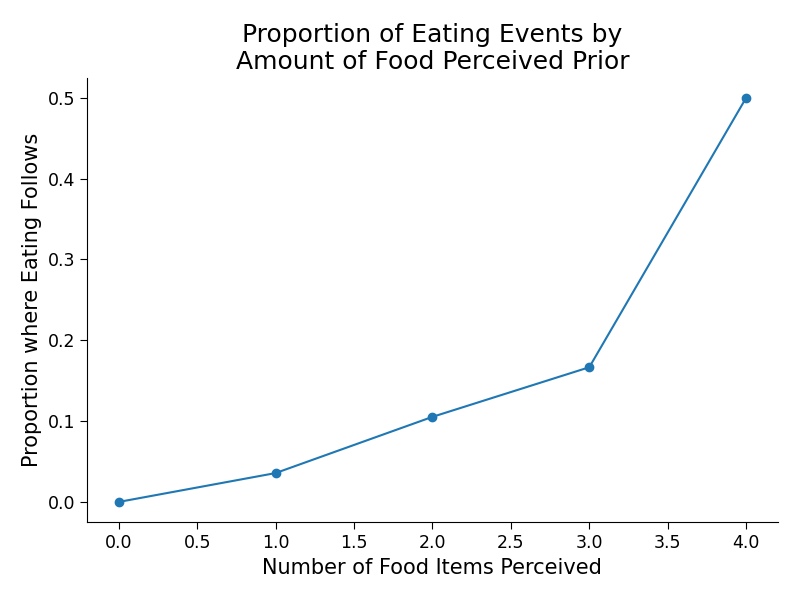

In [ ]:
# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)
prob_eating = data[1][non_zero_cols] / data.sum(axis=0)[non_zero_cols]
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
# Display the plot
plt.show()

In [ ]:
valid_indices = np.where(data.sum(axis=0) > 0)

In [ ]:
valid_indices

(array([0, 1, 2, 3, 4]),)

In [ ]:


# Create a combined array of all perception values
values = np.concatenate([not_eating, eating])
status = np.concatenate([np.repeat('Not Eating', len(not_eating)), np.repeat('Eating', len(eating))])

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Food_in_Perception': values,
    'Status': status
})

# Create box plot
fig_box, ax_box = plt.subplots(figsize=(10,6))
sns.boxplot(x='Status', y='Food_in_Perception', data=df, ax=ax_box)
ax_box.set_title('Distribution of Food in Perception for Eating and Not Eating')
plt.show()

6

In [ ]:
data.nonzero()

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]),
 array([0, 1, 2, 3, 4, 6, 1, 2, 3, 4, 5]))

In [ ]:
np.where(data > 0)[1]

array([0, 1, 2, 3, 4, 6, 1, 2, 3, 4, 5])

*Further reading: how much data is enough:* link to something about power analystis



Now that we have some data

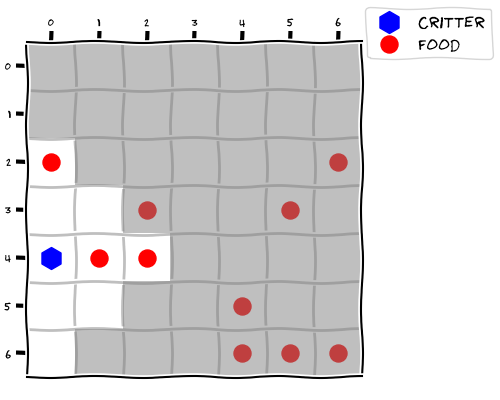

In [ ]:
with plt.xkcd():
  fig, ax = make_grid(7, 7, figsize=(5,4))
  int_locs, rc_index, rc_plotting = init_loc(7, 7, 11, )

  rc_critter = rc_plotting[0]
  plot_critter(fig, ax, rc_critter)

  rc_food = rc_plotting[1:]
  plot_food(fig, ax, rc_food)

  plot_mask(fig, ax, rc_critter, 7, 7, 2)

  fig.legend(loc='outside right upper')
  plt.show()


In [ ]:
############################################################################
## TO DO for students: replace ... with the correct arguments(inputs) is the
## make_grid function below to a grid the right size and shape. You can use the
## tool tip by hovering over the word make_grid to find out how to use it. You
## can also use the tool tip to view the source code. How does it work?
raise NotImplementedError("Student exercise: make grid using the make_grid function")
############################################################################

fig, ax = make_grid(...)

NotImplementedError: ignored

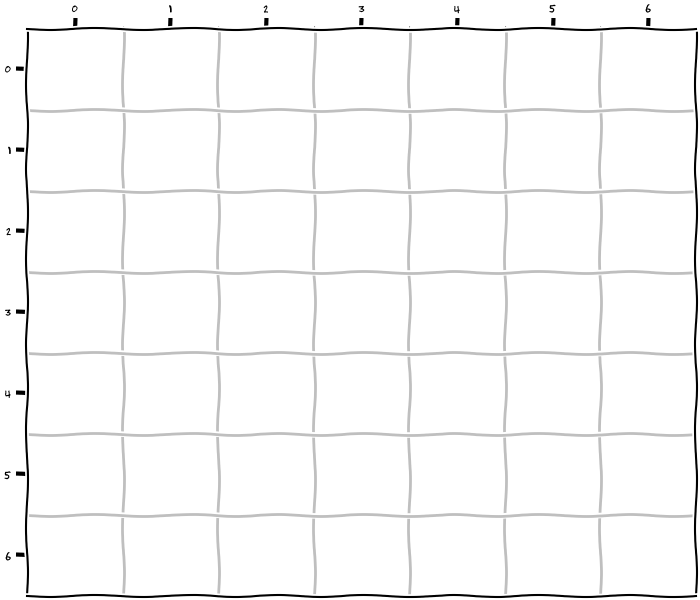

In [ ]:
# to_remove solution

with plt.xkcd():
  fig, ax = make_grid(7, 7)

*Bonus*: Tweak the make_grid function in the Plotting Functions cell above to make the grid lines green.

Wow, what a boring environment. Let's add an organism and something for that organism to interact with. We'll start with 10 food items scattered randomly throughout the grid, never more than one food item per cell. To plot these food items we need their locations. We will set these by randomly sampling grid coordinates [without replacement](## "never picking the same (row,col) coordinate pair twice"). We'll place the organism in the same way and not on a food item to start.

In [ ]:
################################################################################
# TODO for students: replace ... in init_loc(...) to initialize the right
# number of food item locations and critter locations in coordinates that make
# sense for our grid environment. Then replace the ... in rc_plotting[...] to
# index the plotting coordinates for the food locations.
# then comment out or remove the next line.
raise NotImplementedError("Exercise: initialize food and critter locations")
################################################################################
def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting


with plt.xkcd():
  fig, ax = make_grid(7, 7)
  int_locs, rc_index, rc_plotting = init_loc(...)

  rc_critter = (rc_plotting[0])
  plot_critter(fig, ax, rc_critter)

  rc_food = rc_plotting[...]
  plot_food(fig, ax, rc_food)

  fig.legend(loc='outside right upper')

NotImplementedError: ignored

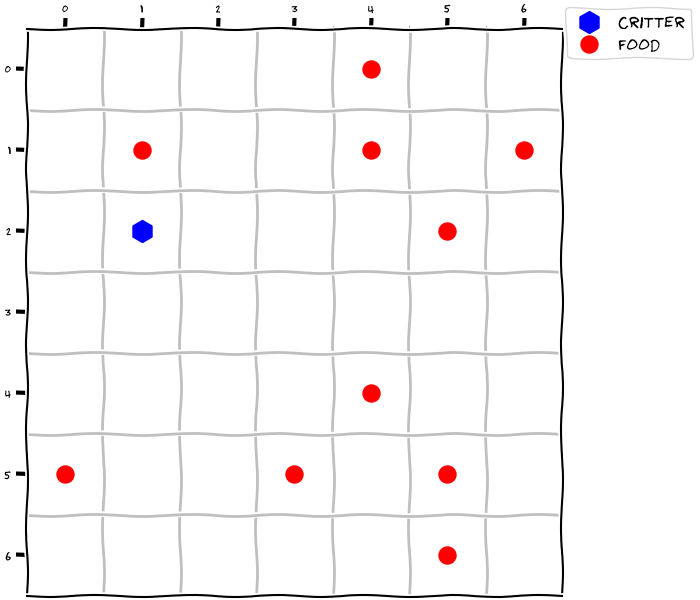

In [ ]:
#to_remove solution


def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting


with plt.xkcd():
  fig, ax = make_grid(7, 7)
  int_locs, rc_index, rc_plotting = init_loc(7, 7, 11)

  rc_critter = (rc_plotting[0])
  plot_critter(fig, ax, rc_critter)

  rc_food = rc_plotting[1:]
  plot_food(fig, ax, rc_food)

  fig.legend(loc='outside right upper')

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 1")

---
# Micro 1.1.1.2: Random Eating

Now that we have an environment scattered with food and an organism, let's introduce some behaviour. The organism drifts around the environment randomly and eats the food it happens to stumble upon. (Can you think of any organisms that employ this strategy?). When food is eaten, the organism gets a **reward**, in this case a *Food Eaten* point, and a new food item appears randomly somewhere else in the environment (that doesn't already have food). Run the code cell below to see what this looks like.

In [ ]:
# @title Random Movement
# @markdown You don't need to worry about how this code works, yet – just **run this cell** and the one below for now and watch what happens

gwg = GridworldGame(1, 7, 7, 10, 30)
random_igwg = InteractiveGridworld(gwg)
display(random_igwg.b_fig.canvas)
clear_output()
display(random_igwg.board_output_and_score)

In [ ]:
# @markdown Run this cell again to watch the random organism play
for ii in range(30):
  time.sleep(0.1)
  random_igwg.random_click()

*Question:* When the organism is just drifting around randomly how good is it at eating lots of food, what is its efficiency in terms of food per movement? Now run the cell above a few more times. Does the organism always eat the same amount of food or does it change between simulation runs?

In [ ]:
# to_remove explanation

"""
The amount of food eaten varies a lot from simulation run to simulation run,
usually it manages to eat one or two pieces of food, sometimes more
sometimes less.
"""

'\nThe amount of food eaten varies a lot from simulation run to simulation run,\nusually it manages to eat one or two pieces of food, sometimes more\nsometimes less.\n'

Before we move on it's important to test that our simulation is running as we expect. Randomness can make testing hard, but can overcome in part by setting up the environment in such a way that the outcome becomes deterministic. In the two cells bellow change how the the Gridworld is initialized. By altering the size, shape and number of food items available create a scenario where the organism will always achieve perfect efficiency and a scenario where the organism will fail completely.

In [ ]:
###############################################################################
# TODO for students: replace the ...'s in GridworldGame(...) to initialize a
# grid world where the organism is always 100% efficient.
raise NotImplementedError("Exercise: make random movement 100% efficient")
################################################################################

gwg = GridworldGame(1, ..., ..., ..., 30)
random_igwg_100 = InteractiveGridworld(gwg)
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.board_output_and_score)

NotImplementedError: ignored

In [ ]:
#to_remove solution
gwg = GridworldGame(1, 2, 2, 3, 30)
random_igwg_100 = InteractiveGridworld(gwg)
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.board_output_and_score)

In [ ]:
for ii in range(30):
  time.sleep(0.1)
  random_igwg_100.random_click()

In [ ]:
###############################################################################
# TODO for students: replace the ...'s in GridworldGame(...) to initialize a
# grid world where the organism is always 0% efficient.
raise NotImplementedError("Exercise: make random movement 0% efficient")
################################################################################

gwg = GridworldGame(1, ..., ..., ..., 30)
random_igwg_0 = InteractiveGridworld(gwg)
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.board_output_and_score)

NotImplementedError: ignored

In [ ]:
#to_remove solution
gwg = GridworldGame(1, 2, 2, 0, 30)
random_igwg_0 = InteractiveGridworld(gwg)
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.board_output_and_score)

In [ ]:
for ii in range(30):
  random_igwg_0.random_click()
  time.sleep(0.1)

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 2")

---
# Micro 1.1.1.3: Better Than Random Eating
Now it's your turn to control the organism. Run the next cell and see how much more efficient than random drifting your control of the organism is in terms of food per movement.

In [ ]:
# @title Controlled Movement
# @markdown You don't need to worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
gwg = GridworldGame(1, 7, 7, 10, 30)
user_control_igwg = InteractiveGridworld(gwg)
display(user_control_igwg.b_fig.canvas)
clear_output()
display(user_control_igwg.boards_buttons_and_score)

Hopefully your performance was more successful than random flailing. Even in this relatively simple and contrived foraging scenario intelligence can help a lot. What kinds of strategies and heuristics did you use to guide your choice of direction? Essentially, the fundamental purpose of a nervous system and a brain is to solve problems of this kind—deciding which actions to take based on environmental inputs to maximize rewards.

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 3")

---
# Micro 1.1.1.4: Optimized Eating
Finally we'd like to introduce a time traveling super organism, GW7x7-10-30, from the last chapter of this book. GW7x7-10-30 has mastered 7x7 Gridworld, with 10 food items and a 30 round duration. Run the next two cells to see how efficient an optimized Gridworld organism can be.

In [ ]:
# @title Optimal Movement
# @markdown You don't need to worry about how this code works – **run this cell** to set up the superorganism and an environment for it.

# initialize the game, network, and MonteCarlo player
gwg = GridworldGame(1, 7, 7, 10, 30)
pvnetMC = PolicyValueNetwork(gwg)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, default_depth=2,
                            default_rollouts=8, default_temp=0.1)


#grab the saved model from the repo or where it ends up being hosted
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

# load the saved model
pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

# set up the widget for display/interaction
optimal_igwg = InteractiveGridworld(gwg)
display(optimal_igwg.b_fig.canvas)
clear_output()
display(optimal_igwg.board_output_and_score)


In [ ]:
# @markdown **Run this cell** to watch the superorganism behave in this environment.

for ii in range(30):
  actions, _, _ = mcp.play(optimal_igwg.board_state)
  directions = gwg.action_to_critter_direction(optimal_igwg.board_state,
                                               actions)
  if directions[0] == 'up':
    optimal_igwg.up_button.click()
  elif directions[0] == 'down':
    optimal_igwg.down_button.click()
  elif directions[0] == 'left':
    optimal_igwg.left_button.click()
  elif directions[0] == 'right':
    optimal_igwg.right_button.click()
  else:
    print('should not happen')

Who was more efficient in this environment you or gw7x7-10-30? If gw7x7-10-30 was better, you really have read this book 😉 (If you can't beat the AIs, at least learn how to program them.) Even if you were about as good as gw7x7-10-30 you still might want to read this book. A deep understanding of the optimization processes that shape behaviour in simple organism-environment systems like this paves the way for generalizition to more intricate systems, specifically, understanding how brains generate adaptive behaviour as a result of optimzation processes.

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 4")

---
# Graveyard


Now, to compare these distributions more directly let's create a [boxplot](## "Sometimes called a box and whisker plot, a boxplot shows the median (middle value), quartiles (25% and 75% values), and outliers of a data set. The 'box' shows the range between the first and third quartiles, the line inside the box is the median, and the 'whiskers' extend to the smallest and largest data points not considered outliers. Outliers are plotted individually.") visualization of the "Number of Food in Items Perceived" variable for the two categories of the outcome: "Not Eating" and "Eating".

In [ ]:
# Create a combined array of all perception values
values = np.concatenate([not_eating, eating])
status = np.concatenate([np.repeat('Not Eating', len(not_eating)),
                         np.repeat('Eating', len(eating))])
# Create a DataFrame for visualization
df = pd.DataFrame({
    'Food Items Perceived': values,
    'Eating Event Type': status})
# Create box plot
fig_box, ax_box = plt.subplots(figsize=(10,6))
sns.boxplot(x='Eating Event Type', y='Food Items Perceived', data=df, ax=ax_box)
ax_box.set_title('Distribution of Food in Perception for Eating and Not Eating')
remove_ip_clutter(fig_box)
plt.show()

Several options on how to host/load the model

1) In the RL NMA tutorial, looks like they used to clone a github repo and pull files directly from there but now looks like they are downloading a snapshot of the repo hosted on open science foundation

```
#!git clone git://github.com/raymondchua/nma_rl_games.git --quiet
REPO_PATH = 'nma_rl_games'

if not os.path.exists(REPO_PATH):
  download_string = "Downloading"
  zipurl = 'https://osf.io/kf4p9/download'
  print(f"{download_string} and unzipping the file... Please wait.")
  with urlopen(zipurl) as zipresp:
    with zipfile.ZipFile(io.BytesIO(zipresp.read())) as zfile:
      zfile.extractall()
  print("Download completed.")

# add the repo in the path
sys.path.append('nma_rl_games/alpha-zero')
print(f"Added the {REPO_PATH} in the path and imported the modules.")

```

But looks like NMA is moving to hosting on open science foundation

```
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']
```

I think eventually we want to do something like hosting more directly on the open science foundation, but for now, using small file sizes we will download files directly from the repo using requests

Useful scavenging from github and SO

In [ ]:
from matplotlib import animation, rc, patches
from IPython.display import HTML

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 11, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(1.5, 10.5, 1), minor=True)
ax.set_yticks(np.arange(1.5, 10.5, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlim(( 0.5, 10.5))
ax.set_ylim(( 0.5, 10.5))

#ax.axis("equal")
scatter = ax.scatter([], [])
#critterCircle = plt.Circle((5,5), 0.4)
#dot = ax.add_patch(critterCircle)
#scatter.set_offsets([[5, 5]])

scatter.set_offsets([[3, 11-3]])
#fig.canvas.draw()
#fig.canvas.flush_events()

In [ ]:
def init():
    scatter.set_offsets([[5, 5]])
    return scatter,

In [ ]:
def animate_dot(i):
    print(i)
    x = i
    y = 11-i
    scatter.set_offsets([[x, y]])
    return scatter,

In [ ]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_dot, init_func=init,
                               frames=(np.arange(10)+1), interval=500, blit=True)

In [ ]:
HTML(anim.to_html5_video())

1
2
3
4
5
6
7
8
9
10


In [ ]:
rc('animation', html='html5')

In [ ]:
anim

These movies are a bit slicker than drawing using the matplotlib figure canvas updates, is this something we can/should incorporate into the non-interactive versions where you just watch something play.

Thoughts to tweak the game, have random movement be something that always happens and directed movement as an optional intervention, maybe on a timer?

